
Reference Papers: The following reference papers may be helpful in providing additional context and specific experimental details:
- [Pacini and Bergman “MINMOD: a computer program to calculate insulin sensitivity and pancreatic responsivity from the frequently sampled intravenous glucose tolerance test”](https://pubmed.ncbi.nlm.nih.gov/3640682/)
- [Steil et al “Feasibilty of Automating Insulin Delivery for the Treatment of Type 1 Diabetes”](https://diabetesjournals.org/diabetes/article/55/12/3344/13146/Feasibility-of-Automating-Insulin-Delivery-for-the)
- [Tolic et al “Modeling the insulin-glucose feedback system: the significance of pulsatile insulin secretion”](https://www.sciencedirect.com/science/article/pii/S0022519300921805?via%3Dihub)
- [Shrestha et al “A mathematical model of parathyroid hormone response to acute changes in plasma ionized calcium concentration in humans”](https://pubmed.ncbi.nlm.nih.gov/20406649/)

In [ ]:
import os
import pdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.io import loadmat

##Building an insulin-glucose model

 I will examine how glucose levels are controlled by an insulin pump following a meal. Given the complexity of this system, it is more practical to simulate glucose levels numerically, rather than solving an intractable system of ODEs.

My goal is to eventually create an `endocrineSystem` function will perform a numerical simulation of the closed loop system.

An engineering challenge that is faced is that a patient might not inject the right amount of needed insulin after each meal as the amount needed for each insulin injection will vary.

A clinical implementation challenge that might be faced if that if a patient has to inject needles of insulin into their system then they might not be compliant for a regular scheudle or correctly administer it.

A continous glucose monitor would solve both of these issues. The patient would not need to inject needles personally into the system with a CGM + closed loop system. This would solve a compliance clinical implementation issue as well as solves the engineering issue by being able to adjust the ideal ammount of insulin to be released.


In [ ]:
t = list(range(0,401))

###  Meal Glucose Subsystem

Implementing a function called mealGlucose that takes in the number of carbs consumed (`carbs`) and the time after the meal (`timeAfterMeal`), and outputs $x_1(t) =$ (grams of carbohydrates consumed) * (total % of glucose at given time after meal) / 15. $x_1(t)$ will tell us the amount of glucose being added to the bloodstream at some time $t$. Output should follow the table below:

$$
\begin{aligned}
& \text {}\\
&\begin{array}{cccc}
\hline \hline \text { Time after Meal (mins) } & \text { Total % of Glucose at Given Time After Meal } \\
\hline 0-15 & 0 \\
15-30 & 3 \\
30-45 & 8 \\
45-60 & 12 \\
60-75 & 18 \\
75-90 & 11 \\
90-105 & 5 \\
105-120 & 2 \\
\hline
\end{array}
\end{aligned}
$$



In [ ]:
def mealGlucose(carbs, timeAfterMeal):

    # carbs: intake carb amount during meal time
    # timeAfterMeal: simulation time
    if (timeAfterMeal < 15):
      percentGlucose = 0
    elif (timeAfterMeal >= 15 and timeAfterMeal < 30):
      percentGlucose = .03
    elif(timeAfterMeal >= 30 and timeAfterMeal < 45):
      percentGlucose = .08
    elif (timeAfterMeal >= 45 and timeAfterMeal < 60):
      percentGlucose = .12
    elif (timeAfterMeal >= 60 and timeAfterMeal < 75):
      percentGlucose = .18
    elif (timeAfterMeal >= 75 and timeAfterMeal < 90):
      percentGlucose = .11
    elif (timeAfterMeal >= 90 and timeAfterMeal < 105):
      percentGlucose = .05
    elif (timeAfterMeal >= 105 and timeAfterMeal < 120):
      percentGlucose = .02
    else:
      percentGlucose = 0
    x1 = (carbs* percentGlucose) /15
    return x1

In [ ]:
# check
output = [mealGlucose(10,95), mealGlucose(33,15),
          mealGlucose(280,4), mealGlucose(112,72)]
print(output)
assert output[0] < 0.1, "Your meal glucose output is too large, double check that you normalized your glucose percentages (see instructions), double check your solution for 1C"
assert output == [0.03333333333333333, 0.066, 0.0, 1.344], "Your meal glucose values are not quite right, double check your solution for part 1C"


[0.03333333333333333, 0.066, 0.0, 1.344]


### Patient Response Subsystem

Implementing a function called `patientResponse` that takes in $x_1$, $x_2$, the current value of $g, X$, and $I$, and the time step `dt` and outputs the simulated values for $g, X$, and $I$ at the next time-step. Will be using the following parameter values: $p_1 = 0.01, p_2 = 0.028, p_3 = 5.0 \times 10^{−5}, V_I = 12, n = 0.0926, g_B = 4.5$, and $I_B = 15$.
` output.

In [ ]:
def patientResponse(x1,x2,g,X,I,dt):

    # define parameters
    ...
    p1= .01
    p2 = .028
    p3 = 5 * 10**-5
    V1 =12
    n = .0926
    gb = 4.5
    Ib = 15

    # This is a sub-function that defines which ODEs to solve
    ...
    def model(y,t):
      g, X, I = y
      dgdt = (-p1*g) - (X*(g+gb))+(x1*dt)
      dXdt = (-p2*X) + (p3*I)
      dIdt = (-n*(I + Ib)) + (1/V1)*x2*dt
      dydt = [dgdt, dXdt, dIdt]
      return dydt
    y0 = [g, X, I]
    t = np.linspace(0,dt,10)
    sol = odeint(model, y0, t)

    ...
    [g, X, I]  = sol[-1,:]
    return g, X, I


In [ ]:
# tests
print("Confirm that your ouput is similar, if not the same to the expected output:")
output = [patientResponse(0.0,0.0,0,0,0,1.0), patientResponse(1.0,1.0,0,0,0,1.0), patientResponse(1.0,1.0,.50,.50,.50,1.0)]
print("Your output:")
print(output)
print("Expected output:")
print([(5.042145032171271e-05, -3.3362987311428505e-05, -1.3266292543080807), (0.9950718777216825, -3.136136764063277e-05, -1.2470378671653022), (-0.6544938668804589, 0.4861863631678784, -0.7912588281492721)])

Confirm that your ouput is similar, if not the same to the expected output:
Your output:
[(5.042145032171271e-05, -3.3362987311428505e-05, -1.3266292543080807), (0.9950718777216825, -3.136136764063277e-05, -1.2470378671653022), (-0.6544938668804589, 0.4861863631678784, -0.7912588281492721)]
Expected output:
[(5.042145032171271e-05, -3.3362987311428505e-05, -1.3266292543080807), (0.9950718777216825, -3.136136764063277e-05, -1.2470378671653022), (-0.6544938668804589, 0.4861863631678784, -0.7912588281492721)]


###  Insulin Pump Subsystem

#### i. Function implementation

Implementing a function called `insulinPump` that takes in values for $g$, $\frac{dg}{dt}$, and the previous integral $I$ value $I_p$ (at time step $n-1$), and outputs $x_2 = P + I + D$ as well as the values for $P$, $I$ and $D$. Will use the following constants $K_P = 10$, $T_I = 150$, and $T_D = 66$ and equations:

$$
\begin{align}
P(n) &= K_p[SG(n) - \text{target}] \\
I(n) &= I(n-1) + K_p / T_I \cdot [SG(n) - \text{target}] \\
D(n) &= K_p \cdot T_D \cdot dSGdt(n) \\
PID(n) &= P(n) + I(n) + D(n) \\
\end{align}
$$

 from the paper “Feasibility of Automating Insulin Delivery for the Treatment of Type 1 Diabetes” (see the paper list at the start of the PSET!).

Assuming that all the units for the variables in your PID system are compatible with the other components of your artificial pancreas model. From *Steil et al.*, $n$ denotes the most recent 1-min value and $n - 1$ denotes the previous value.


In [ ]:
# function that takes in the input of the insulin pump subsystem and returns the correct output

def insulinPump(g, Ip, dgdt):
    # Parameters from Steil et al.
    Kp = 10.0
    TI = 150.0
    TD = 66.0

    P = Kp* (g)
    I = Ip + Kp/TI * (g)
    D = Kp * TD * dgdt
    x2 = P + I + D
    return x2, I, P, D

In [ ]:
#  tests
print("Confirm that your ouput is similar, if not the same to the expected output:")
output = insulinPump(1.0, 2.0, 1.0)
print("Your output:")
print(output)
print("Expected output:")
print([672.0666666666667, 2.066666666666667, 10.0, 660.0])

assert output[1] == 2.066666666666667, "Your integral term is not quite right, double check your solution for part 1D"
assert output[2] == 10.0, "Your proportional term is not quite right, double check your solution for part 1D"
assert output[3] == 660.0, "Your derivative term is not quite right, double check your solution for part 1D"
assert output[0] == 672.0666666666667, "Your x2 value is not quite right, double check your solution for part 1D"

Confirm that your ouput is similar, if not the same to the expected output:
Your output:
(672.0666666666667, 2.066666666666667, 10.0, 660.0)
Expected output:
[672.0666666666667, 2.066666666666667, 10.0, 660.0]


###  Endocrine System

#### i. Putting it together

I will piece them all together to simulate how the entire system behaves over time. I will define a list of carbohydrate intake values (10, 20, 40, 80, 100, 150), i.e. meal sizes, and simulate over 400 minutes what happens to the glucose level `g` and the insulin concentrations `X` and `I`. Assuming that every meal is consumed at $t=0$.


In [ ]:
def endocrineSystem():

    # Define a list of carbs
    carbList = [10,20,40,80,100, 150]


    plt.figure(1)

    # Run the simulation for each intake carb amount
    t = np.linspace(0,401,401)
    for carbs in carbList:
        g = 0.0
        X = 0.0
        I = 0.05
        Ip = 0.0
        dgdt0 = 0.0

        # lists to store the calculated values of g, X, I, and Ip over time
        gv = [g]
        Xv = [X]
        Iv = [I]
        Ipv = [Ip]

        for time in t:
          x1 = mealGlucose(carbs, time)
          if time == 0:
              x2, Int, P, D = insulinPump(g, Ipv[-1],dgdt0)
          else:
              x2, Int, P, D = insulinPump(g, Ipv[-1], gv[-1]-gv[-2])
          g, X, I = patientResponse(x1,x2,g,X,Iv[-1],1)
          gv.append(g)
          Xv.append(Xv)
          Iv.append(I)
          Ipv.append(Int)
        plt.figure(1)
        plt.plot(t, gv[:-1], label=f"{carbs} g")
        Maxg = max(gv)
        Ming = min(gv)
        print(Maxg)
        print(Ming)
    plt.figure(1)
    plt.title("g(t) vs. time")
    plt.xlabel("time (min)")
    plt.ylabel("g(t)")
    plt.legend()

plotting what the glucose levels looks like after different sized meals.

1.7937863270708914
0.0
2.517430662033287
-0.020621184033333274
3.71324781486407
-0.15446592595481703
5.611181281377614
-0.4656755306670613
6.414219153728644
-0.620591108600445
8.169241002718554
-0.974809199323731


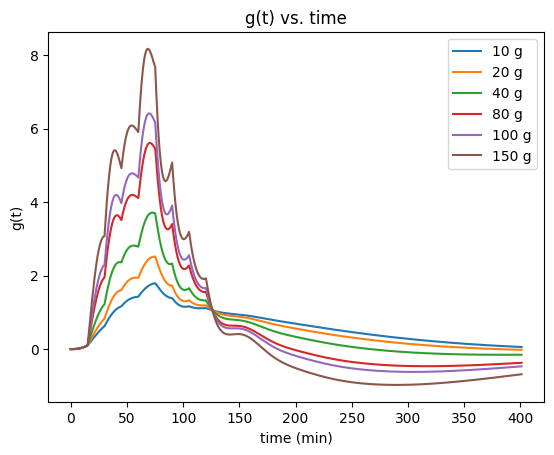

In [ ]:
endocrineSystem()

## Considering an alternative model of diabetes

investigating an alternate model of diabetes as defined in the paper "Modeling the Insulin-Glucose Feedback System: The Significance of Pulsatile Insulin Secretion" by Tolic et al.


$$
\begin{aligned}
& \text {}\\
&\begin{array}{cccc}
\hline \hline \text { Example type } & \text { Onset time } & \text { Duration of peak effectiveness } & \text { Common freq. of taken} \\
\hline \text{Rapid acting: [Novolog]} & \text{[15 mins]} & \text{[1-2hours]} & \text{[Usually taken right before a meal. Often used with longer-acting insulin]}  \\
\text{Short-acting: [Novolin R]} & \text{[30 mins]} & \text{[2-3 hours]} & \text{[Usually taken 30 to 60 minutes before a meal]}  \\
\text{Intermediate-acting: [Novolin N]} & \text{[1-2 hours]} & \text{[4-12]} & \text{[Covers insulin needs for half a day or overnight. Often used with rapid- or short-acting insulin]}  \\
\text{Long-acting: [Levemir]} & \text{[2-4 hours]} & \text{[does not peak]} & \text{[Covers insulin needs for about a full day. Often used, when needed, with rapid- or short-acting insulin]}  \\
\hline
\end{array}
\end{aligned}
$$

### Implement Tolic et al model

Implementing the model from Tolic et al (refer to the first six pages of their paper to understand the model) and to calculate plasma glucose levels as a function of time.

$$
\begin{align}
\frac{dI_p}{dt} &= aI_p + bI_i + cG + d \\
\frac{dI_i}{dt} &= eI_p + fI_i \\
\frac{dG}{dt} &= gI_iG + hG + kx_3 + lx^2_3 + nx^3_3 + p \\
\frac{dx_1}{dt} &= rI_p - rx_1 \\
\frac{dx_2}{dt} &= rx_1 - rx_2 \\
\frac{dx_3}{dt} &= rx_2 - rx_3
\end{align}
$$


The table below contains the relevant constants:

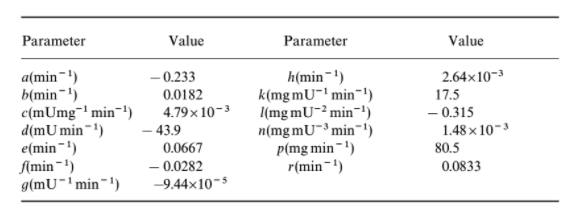

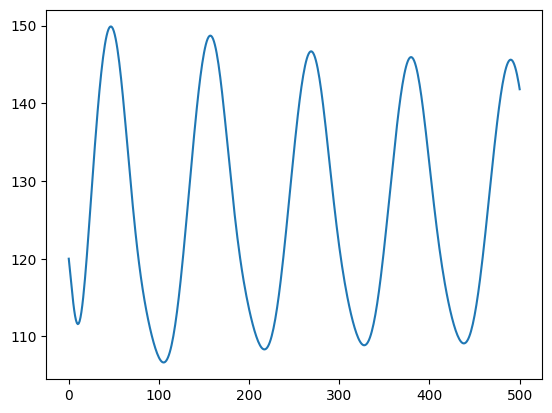

In [ ]:
a = -0.233
b = 0.0182
c = 4.79e-3
d = -43.9
e = 0.0667
f = -0.0282
g = -9.44e-5
h = 2.64e-3
k = 17.5
l = -0.315
n = 1.48e-3
p = 80.5
r = 0.0833

# solving the ODE and plotting glucose over time
t = list(range(0,501,1))
x10 = .1
x20 = .2
x30 = .1
g20 = 12000
Ii0 = 200
Ip0 = 200
y0 = [Ip0, Ii0, g20, x10, x20, x30]
def ODEs(y,t):
  Ip, Ii, g2,x1, x2, x3 = y
  dIpdt = a * Ip + b*Ii + c*g2 + d
  dIidt = e*Ip + f*Ii
  dg2dt = g*Ii*g2 + h*g2 + k*x3 + l*(x3**2)+ n*(x3**3) + p
  dx1dt = r*Ip -r*x1
  dx2dt = r*x1 -r*x2
  dx3dt = r*x2-r*x3
  dydt = [dIpdt, dIidt, dg2dt, dx1dt, dx2dt, dx3dt]
  return dydt
solution = odeint(ODEs, y0, t)
glucose = solution[:,2]/100
plt.plot(t,glucose)


### Incorporating insulin delivery

IN type II diabetes, we are interested in examining the effects of exogenous insulin delivery on her plasma glucose, plasma insulin, and interstitial insulin levels. Assuming that insulin delivery can occur via either oscillatory or constant infusion. Let's model exogenous insulin delivery by updating the equation for $\frac{dI_p}{dt}$ (change in plasma insulin) to the following:

$$
\frac{dI_p}{dt} = m(1 + A \sin(2\pi t / T)) + aI_p
$$

where m = 21 mU/min, A = 0.3 for oscillatory infusion and 0 for constant infusion, and T = 120 minutes; use the initial conditions and constants given in above in C.

Plot the changes in plasma glucose levels for both oscillatory and constant insulin infusion over a total simulation time of 500 minutes.

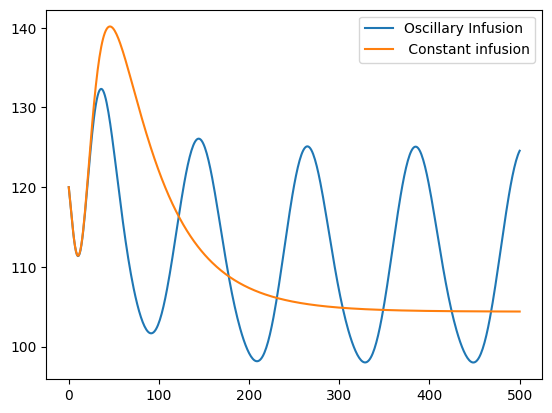

In [ ]:
a = -0.233
b = 0.0182
c = 4.79e-3
d = -43.9
e = 0.0667
f = -0.0282
g = -9.44e-5
h = 2.64e-3
k = 17.5
l = -0.315
n = 1.48e-3
p = 80.5
r = 0.0833

m = 21
A = 0.3
T = 120.

t = list(range(0,501,1))
x10 = .1
x20 = .2
x30 = .1
g20 = 12000
Ii0 = 200
Ip0 = 200
y0 = [Ip0, Ii0, g20, x10, x20, x30]
def ODEs(y,t):
  Ip, Ii, g2,x1, x2, x3 = y
  dIpdt = m*(1+A*np.sin(2*np.pi*t/T))+a*Ip
  dIidt = e*Ip + f*Ii
  dg2dt = g*Ii*g2 + h*g2 + k*x3 + l*(x3**2)+ n*(x3**3) + p
  dx1dt = r*Ip -r*x1
  dx2dt = r*x1 -r*x2
  dx3dt = r*x2-r*x3
  dydt = [dIpdt, dIidt, dg2dt, dx1dt, dx2dt, dx3dt]
  return dydt

def ODE2(y,t):
  Ip, Ii, g2,x1, x2, x3 = y
  dIpdt = m+a*Ip
  dIidt = e*Ip + f*Ii
  dg2dt = g*Ii*g2 + h*g2 + k*x3 + l*(x3**2)+ n*(x3**3) + p
  dx1dt = r*Ip -r*x1
  dx2dt = r*x1 -r*x2
  dx3dt = r*x2-r*x3
  dydt = [dIpdt, dIidt, dg2dt, dx1dt, dx2dt, dx3dt]
  return dydt
solution = odeint(ODEs, y0, t)
solution2 = odeint(ODE2, y0, t)
sol = solution[:,2]/100
sol2 = solution2[:,2]/100
plt.plot(t,sol)
plt.plot(t,sol2)
plt.legend(["Oscillary Infusion", " Constant infusion"])

       












.








  























  

The Oscillary infusion system rises and falls over time. The pros are that this mimics body and rapidly responds to changes but it does require more insulin injections and probably requires engineering on its timing.

constant infusion remains relatively stable and gets to a certian baseline. The pro of this is that requires little work to execute and less injections than the oscillary system. However, this system has a slower response meals and changes to the system.

##  **PTG**
*NExt* we will use parameter estimation to approximate the missing parameter values in our model of parathyroid hormone and plasma calcium activity.

### PTH and calcium


The diagram describes PTH secretion into plasma by the PTG is provided below with corresponding variable names. The variables included in the system are the following: concentration of PTH in the PTG: $c_{PTG}(t)$; concentration of PTH in the plasma: $c_{plasma}(t);$ production of PTH: $p(t)$; rate of PTH removal from the PTG: $k_1$; rate of PTH removal from the plasma: $k_2$; PTH secretion rate: $k_{Ca}(t)$.

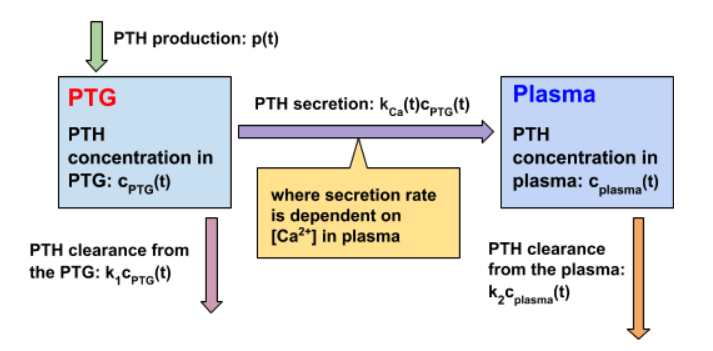
---


dPTG/dt = p(t)-kCa(t)*cptg(t)-k1*cptg(t)

dPTH/dt = kCa(t)*cptg(t)-k2*cplasma(t)

### Model plasma calcium concentration

I want model changes in plasma calcium concentration in a patient with clamp-induced hyperparathyroidism (i.e. calcium is infused into the body, which has led to hypercalcemia). The following equation, from Shrestha et al. will be necessary for your model:

$$
\begin{align}
Ca(t) &= Ca_0, \text{if } t<t_0, \\
Ca(t) &= Ca_0 + Ca_1 (1 - e^{-\alpha (t-t_0)}), \text{if } t \geq t_0
\end{align}
$$

$Ca(t)$ represents the concentration of calcium in plasma, where $Ca_0$ represents the initial steady state baseline concentration, $t_0$ represents the time at which calcium and PTH concentrations change from baseline (i.e. clamp is applied), $\alpha$ represents a decay constant, and $Ca_0 + Ca_1$ represents the steady state concentration after changes from the clamp are observed.

#### Plot calcium data

loading the file `Plasma_Calcium_Patient_Data.mat` (data from Schmitt et al.).

then, plotting the plasma calcium from the patient data (in mmol/L) from the file  to introduce the general behavior of the system you will be working with. Use an x-axis range from t = 540 to 680 minutes for the plots;


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


(540.0, 680.0, 1.0, 1.6)

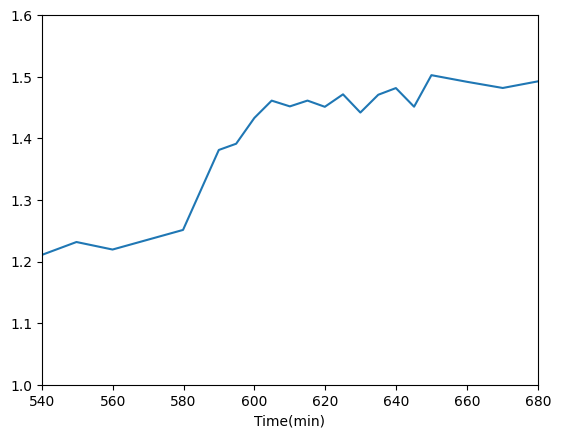

In [ ]:
# Loading in the Calcium Data
filepath = "/content/drive/MyDrive/Plasma_Calcium_Patient_Data.mat"
Ca_Data_File = loadmat(filepath)

Ca_Data = Ca_Data_File['Plasma_Ca']
Ca_Data = [Ca[0] for Ca in Ca_Data]
Time = Ca_Data_File['Ca_Time']
Time = [T[0] for T in Time]

# plotting the calcium data
plt.plot(Time,Ca_Data)
plt.xlabel("Time(min)")
plt.ylabel("")
plt.axis([540,680,1,1.6])


#### Parameter Estimation

I will write code to estimate the parameter values for t0, a, Ca0 and Ca1, and then plot  predicted plasma calcium curve against the actual data.

([<matplotlib.lines.Line2D at 0x7fac364c2be0>],
 [<matplotlib.lines.Line2D at 0x7fac364c26d0>])

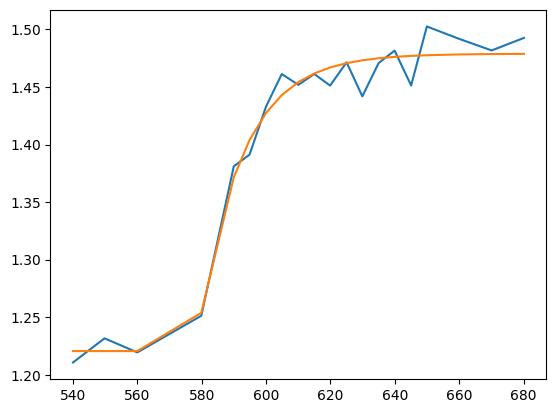

In [ ]:
# piecewise function
def Cafunc(t, Ca0, Ca1, alpha, t0):
    condlist = [t < t0, t >= t0 ]
    funclist = [lambda t:Ca0, lambda t:Ca0 + Ca1*(1-np.exp(-alpha*(t-t0))) ]
    y = np.piecewise(t, condlist, funclist)
    return y

# parameter estimates and bounds
Ca0 = 1.2
Ca1 = 1.5
alpha = .1
t0 = 580
p0 = [Ca0, Ca1, alpha,t0]
bounds = [(-np.inf,-np.inf,0,-np.inf),(np.inf,np.inf,.5,np.inf)]
t = np.linspace(0,501,20)
popt, pcov = curve_fit(Cafunc, Time, Ca_Data, p0=p0, bounds=bounds)

# plotting estimated values and the patient data
predicted = Cafunc(Time,popt[0], popt[1], popt[2], popt[3])
plt.plot(Time, Ca_Data), plt.plot(Time,predicted)






 Ca0 = 1.2 (where the intial point is near)

Ca1 = 1.5 (where the last point is near)

t0 = 580 (where graph changes and rises rapidly)
